This script is designed to create a deep neural network that will predict the fractional cover of Poa secunda within the big sagebrush region. The model is built on data collected by the BLM for their AIM monitoring protocol and is open to public use. The network created here has four hidden layers.



In [ ]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load in the dataset

In [ ]:
dataset = pd.read_csv('/content/POINT_DATA_FINAL.csv')

Look at the data

In [ ]:
print(dataset.head())

Drop the variables that are not of interest for this model

In [ ]:
dataset = dataset.drop(['deep.silt','deep.clay','deep.sand','deep.rock','deep.efferv','DateVisited','Unnamed: 0',
                        'Unnamed: 0.1','PrimaryKey','POSE_count','Unnamed: 0.1.1','NEAR_DIST',
                        'Spp_Sagebrush'],axis=1)

Look at the order of the columns

In [ ]:
print(dataset.columns.tolist())

Get a first look at the data

In [ ]:
print(dataset.describe())

The variable that we are wanting to predict for is POSE_cover (1st column)

In [ ]:
labels = dataset.iloc[:,0]
features = dataset.iloc[:,1:]

Normalize the numerical data and create dummy variables for categorical data

In [ ]:
features = pd.get_dummies(dataset)
features_train, features_test, labels_train, labels_test = train_test_split(features,labels,test_size = 0.33, random_state = 1234)
numerical_features = features.select_dtypes(include=['float64','int64'])
numerical_columns = numerical_features.columns
ct = ColumnTransformer([('only numeric',StandardScaler(),numerical_columns)],remainder='passthrough')
features_train_scaled = ct.fit_transform(features_train)
features_test_scaled = ct.transform(features_test)

Define a function that will create the model

In [ ]:
def design_model(X, learning_rate):
  my_model = Sequential()
  input = InputLayer(input_shape=(features.shape[1],))
  my_model.add(input)

  my_model.add(Dense(1024,activation = 'relu'))
  my_model.add(layers.BatchNormalization())
  my_model.add(layers.Dropout(0.5))

  my_model.add(Dense(512,activation='relu'))
  my_model.add(layers.BatchNormalization())
  my_model.add(layers.Dropout(0.5))

  my_model.add(Dense(256,activation='relu'))
  my_model.add(layers.BatchNormalization())
  my_model.add(layers.Dropout(0.2))

  my_model.add(Dense(256,activation='relu'))
  my_model.add(layers.BatchNormalization())
  my_model.add(layers.Dropout(0.4))
  my_model.add(Dense(1))

  #opt = Adam(learning_rate = 0.00001,decay=0.0005)
  opt = SGD(learning_rate=learning_rate)
  #print(my_model.summary())
  my_model.compile(loss='mse',metrics=['mae'],optimizer=opt)
  print(my_model.summary())
  return my_model

Define a function that will fit the model to the data

In [ ]:
def fit_model(model, f_train, l_train, learning_rate, num_epochs):
    #train the model on the training data
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 20)
    history = model.fit(f_train, l_train, epochs=num_epochs, batch_size= 2, verbose=0, validation_split = 0.2, callbacks = [es])
    print('mae','mse')
    return history

Define a function that will plot the mean squared error and the mean absolute error from model fitting

In [ ]:
def plot(history):
    # plot learning curves
    fig, axs = plt.subplots(1, 2, gridspec_kw={'hspace': 1, 'wspace': 0.8}) 
    (ax1, ax2) = axs
    ax1.plot(history.history['loss'], label='train')
    ax1.plot(history.history['val_loss'], label='validation')
    ax1.set_title('lrate=' + str(learning_rate))
    ax1.legend(loc="upper right")
    ax1.set_xlabel("# of epochs")
    ax1.set_ylabel("loss (mse)")

    ax2.plot(history.history['mae'], label='train')
    ax2.plot(history.history['val_mae'], label='validation')
    ax2.set_title('lrate=' + str(learning_rate))
    ax2.legend(loc="upper right")
    ax2.set_xlabel("# of epochs")
    ax2.set_ylabel("MAE")
    print("Final validation MAE:", history.history['val_mae'][-1])

Using the model described above, fit a model with a learning rate of 0.00001 and 10 epochs

In [ ]:
learning_rate = 0.00001
num_epochs = 10
model_run1= fit_model(design_model(features_train_scaled, learning_rate),
                     features_train_scaled, 
                     labels_train, 
                     learning_rate, 
                     num_epochs)

Use the plot function on the model run created above

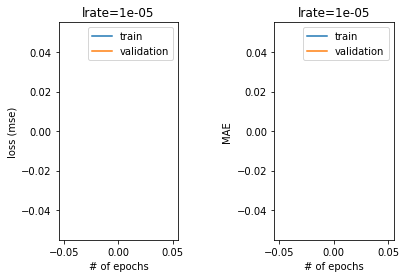

In [ ]:
plot(model_run1)

See the history of the model

In [ ]:
model_run1.history

{'loss': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
 'mae': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
 'val_loss': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
 'val_mae': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]}

Perform a model fit to evaluate predictive abilities

In [ ]:
model = design_model(features_train_scaled, learning_rate)
model.fit(
    features_train_scaled,
    labels_train,
    batch_size=2,
    epochs=10,
    )

Evaluate the model and generate predictions

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(features_test_scaled, labels_test, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(features_test_scaled[:3])
print("predictions shape:", predictions.shape)